In [290]:
import os
import pandas as pd

def load_bm25_data(root_folder):
    bm25_data = {}

    # Iterate through the retriever folders
    for retriever_folder in os.listdir(root_folder):
        retriever_path = os.path.join(root_folder, retriever_folder)

        # Check if it's a directory
        if os.path.isdir(retriever_path):
            retriever_data = {}

            # Iterate through language folders (de, en, etc.)
            for lang_folder in os.listdir(retriever_path):
                lang_path = os.path.join(retriever_path, lang_folder)

                # Check if it's a directory
                if os.path.isdir(lang_path):
                    index_data = {}

                    # Iterate through index folders
                    for index_folder in os.listdir(lang_path):
                        index_path = os.path.join(lang_path, index_folder)

                        # Check if it's a directory
                        if os.path.isdir(index_path):
                            # Load all CSV files in the index folder
                            index_files = {}
                            for csv_file in os.listdir(index_path):
                                if csv_file.endswith('.csv'):
                                    csv_path = os.path.join(index_path, csv_file)
                                    df = pd.read_csv(csv_path)
                                    index_files[csv_file] = df

                            index_data[index_folder] = index_files

                    retriever_data[lang_folder] = index_data

            bm25_data[retriever_folder] = retriever_data

    # Concatenate the DataFrames within the nested dictionary
    for retriever, retriever_data in bm25_data.items():
        for lang, lang_data in retriever_data.items():
            for index, index_files in lang_data.items():
                concatenated_df = pd.concat(index_files.values(), ignore_index=True)
                
                # Sort the DataFrame based on the "k" column
                concatenated_df = concatenated_df.sort_values(by='k')
                
                # Reset the index
                concatenated_df = concatenated_df.reset_index(drop=True)

                bm25_data[retriever][lang][index] = concatenated_df

    return bm25_data

root_folder = "./benchmarks-retriever"

# Load the BM25 data
data = load_bm25_data(root_folder)

# Access the concatenated, sorted, and reset index DataFrame for BM25 retriever, language 'de', index 'translated_IndexEnglishAll'
df_combined_sorted = data['bm25']['de']['translated_IndexEnglishAll']
print(df_combined_sorted)

   Retriever     k        HR       MRR
0       BM25     1  0.183295  0.183295
1       BM25     3  0.283473  0.227119
2       BM25     5  0.331586  0.238078
3       BM25    10  0.402085  0.247408
4       BM25    15  0.449383  0.251129
5       BM25    25  0.514843  0.254438
6       BM25    50  0.610612  0.257162
7       BM25   100  0.702672  0.258492
8       BM25   150  0.742715  0.258823
9       BM25   200  0.768902  0.258974
10      BM25   300  0.802740  0.259113
11      BM25   400  0.823531  0.259174
12      BM25   500  0.840124  0.259211
13      BM25  1000  0.884777  0.259276


In [291]:
data

{'dpr': {'de': {'translated_IndexEnglishAll':    Retriever    k        HR       MRR
   0   largeDPR    1  0.300796  0.300796
   1   largeDPR    3  0.439959  0.362059
   2   largeDPR    5  0.502232  0.376290
   3   largeDPR   10  0.586524  0.387556
   4   largeDPR   15  0.586524  0.387556
   5   largeDPR   25  0.586524  0.387556
   6   largeDPR   50  0.586524  0.387556
   7   largeDPR  100  0.586524  0.387556
   8   largeDPR  150  0.586524  0.387556
   9   largeDPR  200  0.586524  0.387556
   10  largeDPR  300  0.586524  0.387556
   11  largeDPR  400  0.586524  0.387556,
   'IndexGermanAll':    Retriever     k        HR       MRR
   0   largeDPR     1  0.235225  0.235225
   1   largeDPR     3  0.342329  0.282504
   2   largeDPR     5  0.389765  0.293309
   3   largeDPR    10  0.459314  0.302535
   4   largeDPR    15  0.459314  0.302535
   5   largeDPR    25  0.459314  0.302535
   6   largeDPR    50  0.459314  0.302535
   7   largeDPR   100  0.459314  0.302535
   8   largeDPR   150  0.45

In [292]:
def post_process_bm25_data(data):
    new_bm25_data = data.copy()

    # Iterate through the retriever folders
    for retriever, retriever_data in data.items():
        if retriever.startswith('bm25_ce'):
            new_retriever_data = {}
            for lang, lang_data in retriever_data.items():
                new_lang_data = {}
                for index, df in lang_data.items():
                    # Add a new column "k_inner" to the DataFrame
                    df['k_inner'] = df['Retriever'].str.split('-CE-k').str[0].str.split('-k').str[1].astype(int)
                    new_lang_data[index] = df.copy()  # Copy the modified DataFrame
                new_retriever_data[lang] = new_lang_data
            new_bm25_data[retriever] = new_retriever_data

    # Return the new dictionary
    return new_bm25_data


In [293]:
bm25_data = load_bm25_data(root_folder)

In [294]:
bm25_data_post_processed = post_process_bm25_data(bm25_data)

In [295]:
def group_and_rename(data):
    new_data = data.copy()

    for language, language_data in data['bm25_ce'].copy().items():
        for index_name, index_data in language_data.items():
            if isinstance(index_data, pd.DataFrame):
                for index, retriever_data in index_data.groupby('k_inner'):
                    retriever_name = f'bm25_ce_{index}'

                    # Ensure the necessary keys exist before accessing/modifying
                    if retriever_name not in new_data:
                        new_data[retriever_name] = {}
                    if language not in new_data[retriever_name]:
                        new_data[retriever_name][language] = {}
                    if index_name not in new_data[retriever_name][language]:
                        new_data[retriever_name][language][index_name] = {}

                    new_data[retriever_name][language][index_name] = retriever_data

                # Remove the old key
                # del new_data['bm25_ce'][language][index_name]

    return new_data

In [296]:
bm25_grouped = group_and_rename(bm25_data_post_processed)

In [297]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

In [298]:
bm25_grouped['bm25_ce_1000']['en']['IndexEnglishAll']

,Retriever,k,HR,MRR,k_inner
7,BM25-k1000-CE-k1,1,0.289670,0.289670,1000
21,BM25-k1000-CE-k3,3,0.412333,0.343724,1000
35,BM25-k1000-CE-k5,5,0.468588,0.356579,1000
46,BM25-k1000-CE-k10,10,0.553105,0.367850,1000


In [299]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

In [300]:
bm25_grouped['dpr']['en']['IndexEnglishAll'].columns

Index(['Retriever', 'k', 'HR', 'MRR'], dtype='object')

In [301]:
data = bm25_grouped

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns

In [303]:
bm25_grouped['dpr'].keys()

dict_keys(['de', 'en'])

In [304]:
print(bm25_grouped['dpr']["en"].keys())
print(bm25_grouped['dpr']["de"].keys())

dict_keys(['IndexEnglishAll', 'translated_IndexGermanAll'])
dict_keys(['translated_IndexEnglishAll', 'IndexGermanAll'])


In [305]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_indices_comparison(bm25_grouped, selected_retrievers, selected_indices, metric='HR', max_k=None):
    # Extracting data for specified retrievers and all languages
    indices = set()
    for retriever in selected_retrievers:
        for lang in bm25_grouped[retriever]:
            indices.update(bm25_grouped[retriever][lang].keys())

    # Filter indices based on selected_indices
    indices = [index for index in indices if index in selected_indices]

    # Set seaborn style
    sns.set(style="darkgrid")

    # Create a color palette with distinct colors for each index
    palette = sns.color_palette("husl", n_colors=len(indices))

    # Define line styles based on the number of selected retrievers
    line_styles = ['solid', 'dotted', 'dashed', 'dashdot'] * (len(selected_retrievers) // 4 + 1)

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, index in enumerate(indices):
        for j, retriever in enumerate(selected_retrievers):
            for lang in bm25_grouped[retriever]:
                if index in bm25_grouped[retriever][lang]:
                    data = bm25_grouped[retriever][lang][index]

                    # Apply max_k if provided
                    if max_k is not None:
                        data = data[data['k'] <= max_k]

                    # Use uppercase retriever names for consistency
                    sns.lineplot(x='k', y=metric, data=data, label=f'{retriever.upper()} - {index} ({lang})', color=palette[i], linestyle=line_styles[j % len(line_styles)])
                    plt.scatter(data['k'], data[metric], color=palette[i], marker='o', s=20)  # Add dots on the line at data points

    # Set labels and title dynamically
    retriever_str = ', '.join(selected_retrievers)
    # Full CAPS for retriever names
    retriever_str = retriever_str.upper()
    index_str = ', '.join(selected_indices)
    max_k_str = f', Max k = {max_k}' if max_k is not None else ''

    # Check if more than 2 retrievers are selected
    if len(selected_retrievers) > 2:
        retriever_str = 'multiple'
    
    if len(selected_indices) > 2:
        index_str = 'multiple'

    plt.xlabel('k')
    plt.ylabel(metric)
    
    # Add space below the title
    plt.title(f'{metric} for {retriever_str} retriever over {index_str} indices{max_k_str}', pad=20)

    # Add legend
    plt.legend()

    # Add space below the graph
    plt.subplots_adjust(bottom=0.15)

    # Show the plot
    plt.show()


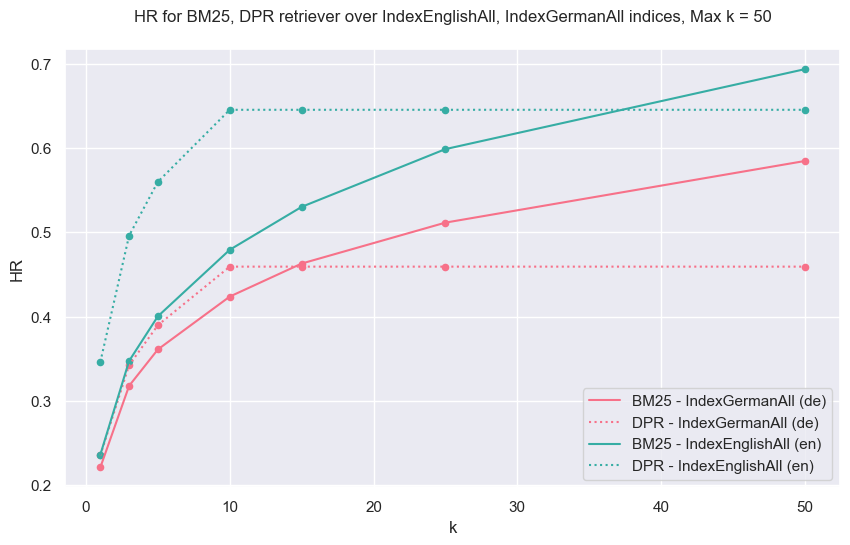

In [321]:
# Graph 1
# Welcher Retriever performt am besten bei k=1000

plot_indices_comparison(bm25_grouped, ['bm25', 'dpr'], ['IndexEnglishAll', "IndexGermanAll"], metric='HR', max_k=50)

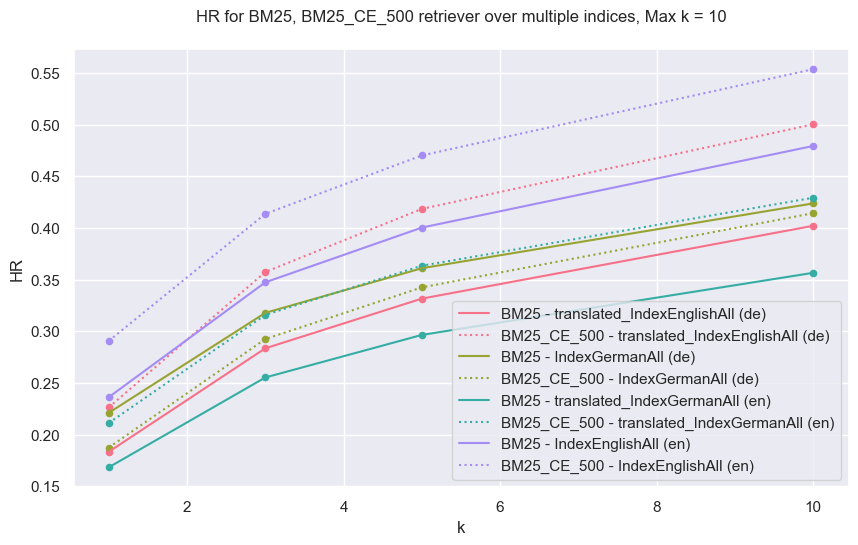

In [319]:
# Graph 2
# Warum Ensemble Retrieval besser ist als BM25

plot_indices_comparison(bm25_grouped, ['bm25', 'bm25_ce_500'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='HR', max_k=10)

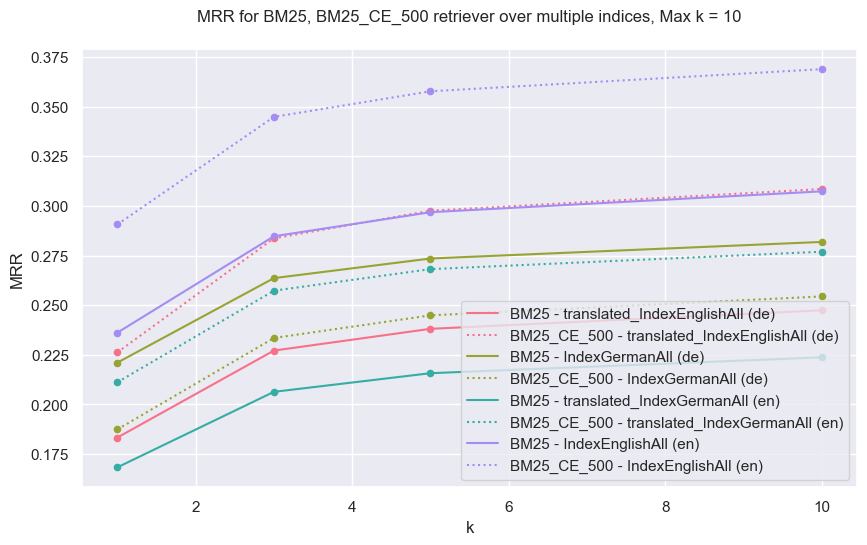

In [320]:
# Graph 3
# Warum Ensemble Retrieval besser ist als BM25

plot_indices_comparison(bm25_grouped, ['bm25', 'bm25_ce_500'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='MRR', max_k=10)

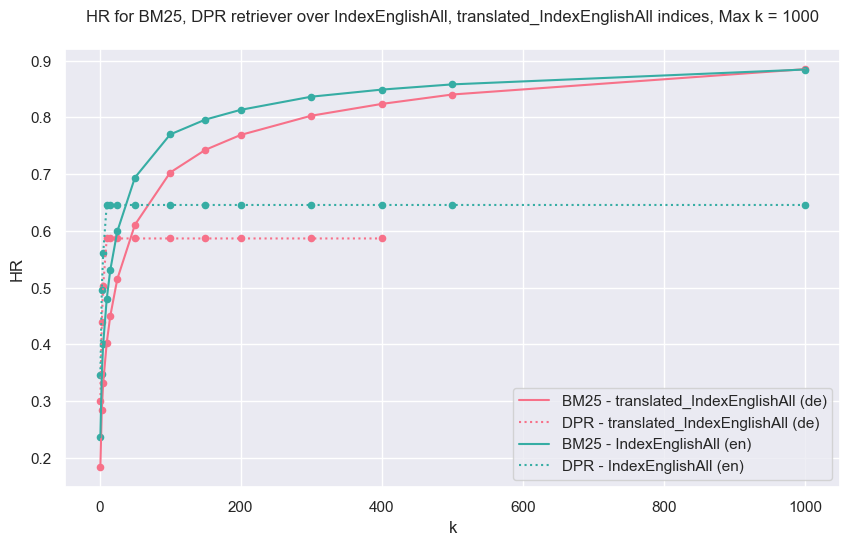

In [309]:
# Graph 4
# Unterschied zwischen Sprachen?

plot_indices_comparison(bm25_grouped, ['bm25', 'dpr'], ['IndexEnglishAll', "translated_IndexEnglishAll"], metric='HR', max_k=1000)

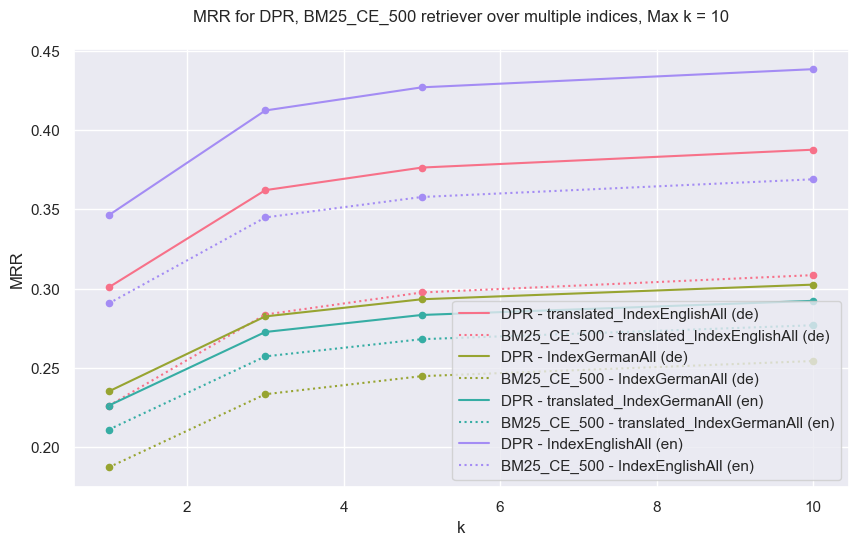

In [310]:
# Graph 5
# Welcher ist der beste Retriever für den Use-Case?

plot_indices_comparison(bm25_grouped, ['dpr', 'bm25_ce_500'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='MRR', max_k=10)

In [322]:
bm25_grouped.keys()

dict_keys(['dpr', 'bm25_ce', 'bm25', 'bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'])

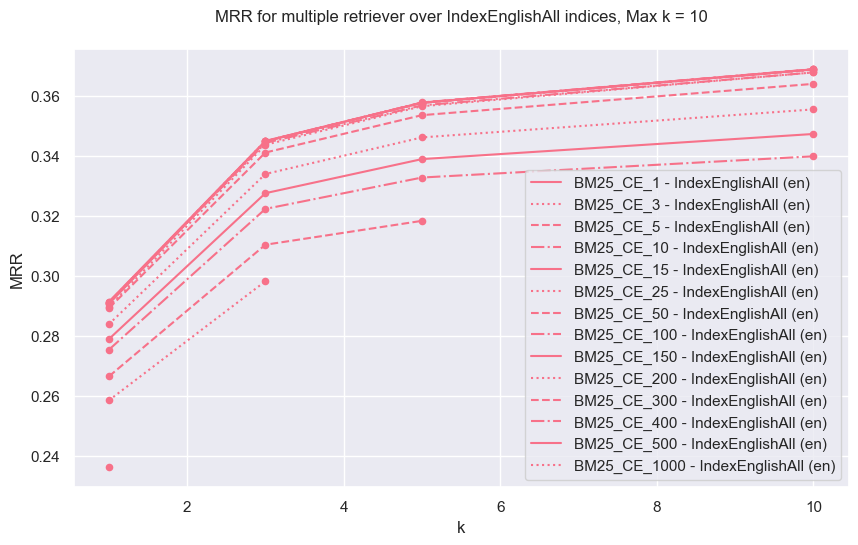

In [323]:
plot_indices_comparison(bm25_grouped, ['bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'], ['IndexEnglishAll'], metric='MRR', max_k=10)

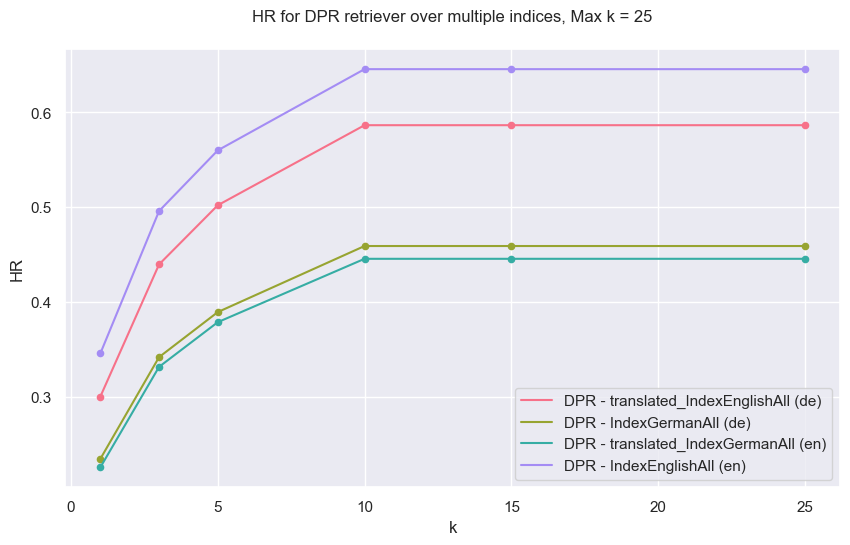

In [315]:
# Graph 6 (For Data Generation Evaluation)
# Was ist der Qualitätsunterschied zwischen den Indices?

plot_indices_comparison(bm25_grouped, ['dpr'], ['IndexEnglishAll', "IndexGermanAll", "translated_IndexEnglishAll", "translated_IndexGermanAll"], metric='HR', max_k=25)

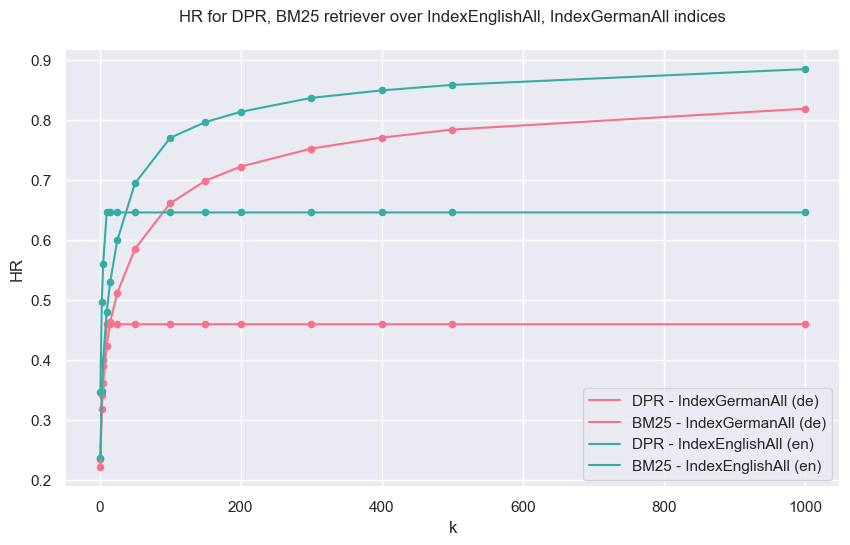

In [332]:
def plot_indices_comparison(bm25_grouped, selected_retrievers, selected_indices, metric='HR', max_k=None, consistent_line_style=False):

    # Extracting data for specified retrievers and all languages
    indices = set()
    for retriever in selected_retrievers:
        for lang in bm25_grouped[retriever]:
            indices.update(bm25_grouped[retriever][lang].keys())

    # Filter indices based on selected_indices
    indices = [index for index in indices if index in selected_indices]

    # Set seaborn style
    sns.set(style="darkgrid")

    # Create a color palette with distinct colors for each index
    palette = sns.color_palette("husl", n_colors=len(selected_retrievers))

    # Define line style if consistent_line_style is True
    line_style = 'solid' if consistent_line_style else None

    # Plotting
    plt.figure(figsize=(10, 6))

    for i, index in enumerate(indices):
        for j, retriever in enumerate(selected_retrievers):
            for lang in bm25_grouped[retriever]:
                if index in bm25_grouped[retriever][lang]:
                    data = bm25_grouped[retriever][lang][index]

                    # Apply max_k if provided
                    if max_k is not None:
                        data = data[data['k'] <= max_k]

                    # Use uppercase retriever names for consistency
                    sns.lineplot(x='k', y=metric, data=data, label=f'{retriever.upper()} - {index} ({lang})', color=palette[j], linestyle=line_style)
                    plt.scatter(data['k'], data[metric], color=palette[j], marker='o', s=20)  # Add dots on the line at data points

    # Set labels and title dynamically
    retriever_str = ', '.join(selected_retrievers)
    # Full CAPS for retriever names
    retriever_str = retriever_str.upper()
    index_str = ', '.join(selected_indices)
    max_k_str = f', Max k = {max_k}' if max_k is not None else ''

    # Check if more than 2 retrievers are selected
    if len(selected_retrievers) > 2:
        retriever_str = 'multiple'
    
    if len(selected_indices) > 2:
        index_str = 'multiple'

    plt.xlabel('k')
    plt.ylabel(metric)
    
    # Add space below the title
    plt.title(f'{metric} for {retriever_str} retriever over {index_str} indices{max_k_str}', pad=20)

    # Add legend
    plt.legend()

    # Add space below the graph
    plt.subplots_adjust(bottom=0.15)

    # Show the plot
    plt.show()

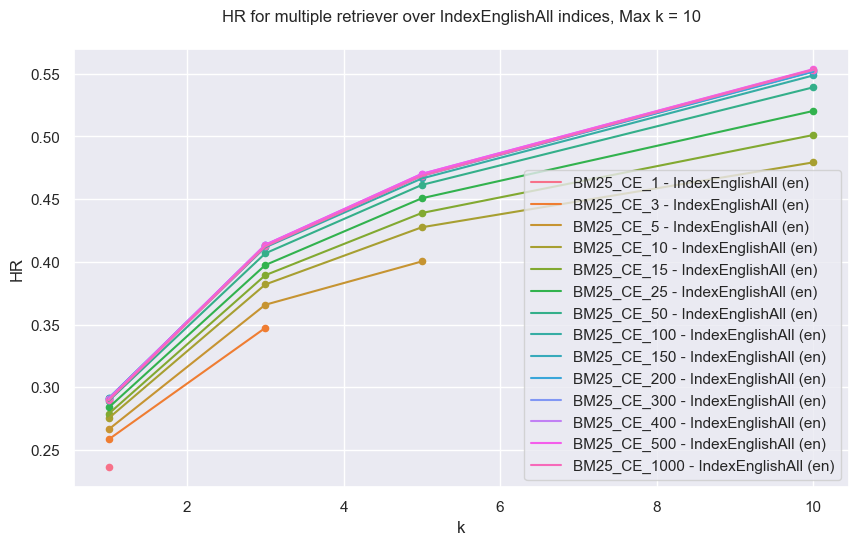

In [334]:
plot_indices_comparison(bm25_grouped, ['bm25_ce_1', 'bm25_ce_3', 'bm25_ce_5', 'bm25_ce_10', 'bm25_ce_15', 'bm25_ce_25', 'bm25_ce_50', 'bm25_ce_100', 'bm25_ce_150', 'bm25_ce_200', 'bm25_ce_300', 'bm25_ce_400', 'bm25_ce_500', 'bm25_ce_1000'], ['IndexEnglishAll'], metric='HR', max_k=10, consistent_line_style=True)